In [4]:
%load_ext autoreload
%autoreload 2

In [14]:
# ===============================
# PHASE 4: DATA REDUCTION
# ===============================

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import sys
import os

In [15]:
path = os.path.abspath("../")
if(path not in sys.path):
    sys.path.append(path)

In [16]:
from src.Read_Any_File_Type import reading_data

# Load transformed dataset
file_path = "../data/interim/Diabetes-Transformed.csv"
data = reading_data(file_path)
df=data.read_data()

[SUCCESS] File loaded successfully: <class 'pandas.core.frame.DataFrame'>


=== FEATURE SELECTION ===


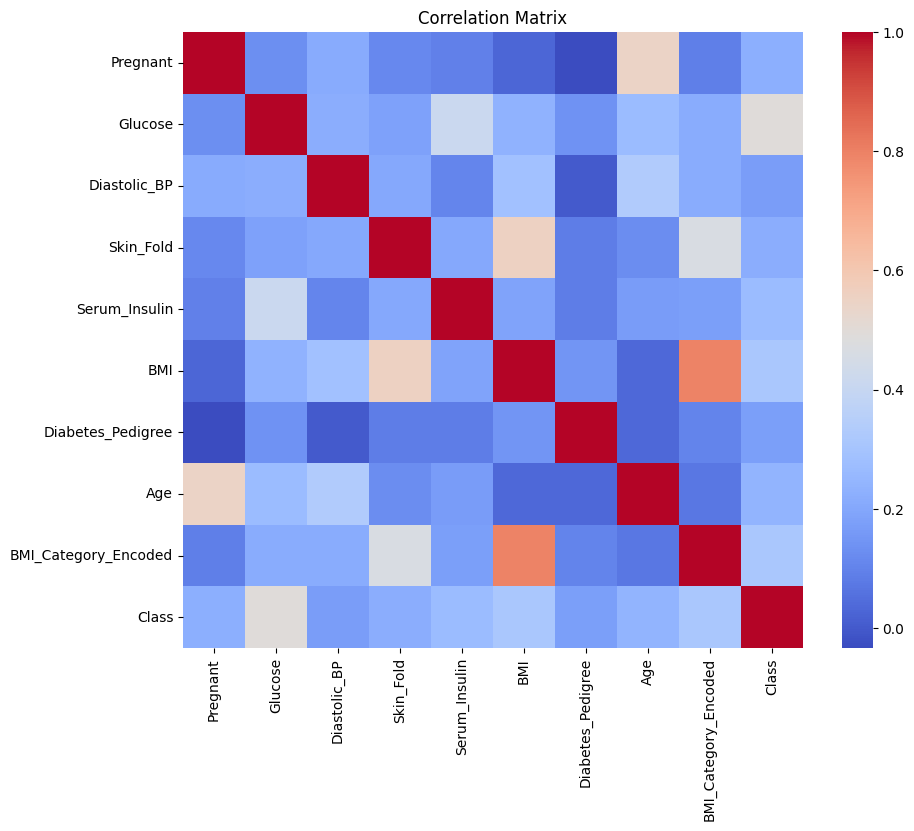


Top features correlated with 'Class':
 Class                   1.000000
Glucose                 0.492782
BMI                     0.312811
BMI_Category_Encoded    0.309762
Serum_Insulin           0.266382
Age                     0.238356
Pregnant                0.221898
Skin_Fold               0.220111
Diabetes_Pedigree       0.173844
Diastolic_BP            0.168971
Name: Class, dtype: float64

=== SELECTKBEST (Mutual Information) RESULTS ===
                    Feature     Score
1                   Glucose  0.126588
5                       BMI  0.063279
8      BMI_Category_Encoded  0.059652
10          Age_Group_Young  0.055412
7                       Age  0.052012
3                 Skin_Fold  0.042685
13       BMI_Category_Obese  0.042664
11  Glucose_Category_Normal  0.036839
14  BMI_Category_Overweight  0.022914
0                  Pregnant  0.018110

Selected top 8 features: ['Glucose', 'BMI', 'BMI_Category_Encoded', 'Age_Group_Young', 'Age', 'Skin_Fold', 'BMI_Category_Obese', 'Glu

In [17]:
# =======================================================
# 1️⃣ FEATURE SELECTION
# =======================================================

print("=== FEATURE SELECTION ===")

# Separate features (X) and target (y)
X = df.drop(columns=['Class'])
y = df['Class']

# --- a) Correlation Matrix (numeric only) ---
numeric_df = X.select_dtypes(include=[np.number])  # select numeric features only
numeric_df['Class'] = y  # temporarily add target for correlation

plt.figure(figsize=(10, 8))
corr = numeric_df.corr()
sns.heatmap(corr, annot=False, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

# Display top correlated features with target
corr_target = corr['Class'].sort_values(ascending=False)
print("\nTop features correlated with 'Class':\n", corr_target.head(10))

# --- b) SelectKBest using Mutual Information ---
# Encode categorical features if needed
X_encoded = pd.get_dummies(X, drop_first=True)  # converts categorical to numeric

selector = SelectKBest(score_func=mutual_info_classif, k=8)
selector.fit(X_encoded, y)
scores = pd.DataFrame({'Feature': X_encoded.columns, 'Score': selector.scores_})
scores = scores.sort_values(by='Score', ascending=False)

print("\n=== SELECTKBEST (Mutual Information) RESULTS ===")
print(scores.head(10))

# Select top features
selected_features = scores['Feature'].head(8).tolist()
X_selected = X_encoded[selected_features]
print("\nSelected top 8 features:", selected_features)


=== PCA ANALYSIS ===


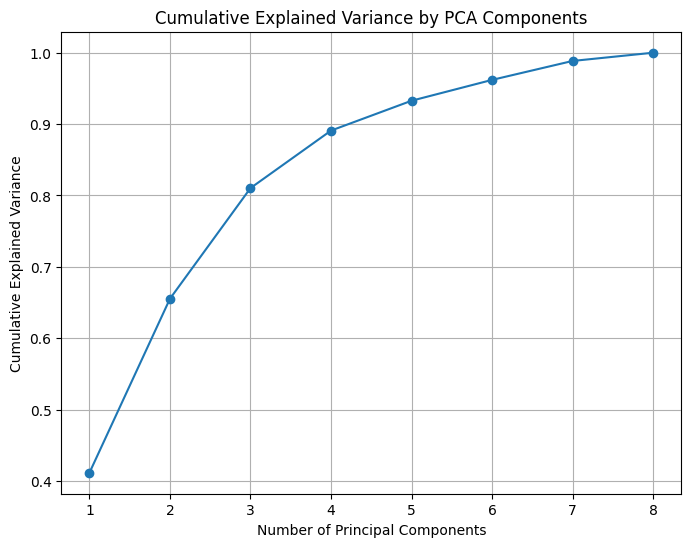


Optimal number of PCA components to retain 95% variance: 6

✅ PCA transformation complete.
New shape after PCA: (768, 7)


In [18]:
# =======================================================
# 2️⃣ DIMENSIONALITY REDUCTION (PCA)
# =======================================================

print("\n=== PCA ANALYSIS ===")

# Standardize data before PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

# Perform PCA
pca = PCA()
pca.fit(X_scaled)
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot variance explained
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance)+1), explained_variance, marker='o')
plt.title("Cumulative Explained Variance by PCA Components")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.show()

# Determine optimal number of components (e.g., 95% variance)
optimal_components = np.argmax(explained_variance >= 0.95) + 1
print(f"\nOptimal number of PCA components to retain 95% variance: {optimal_components}")

# Apply PCA with optimal components
pca_final = PCA(n_components=optimal_components)
X_pca = pca_final.fit_transform(X_scaled)

# Create DataFrame for PCA-transformed data
pca_columns = [f"PC{i+1}" for i in range(optimal_components)]
df_pca = pd.DataFrame(X_pca, columns=pca_columns)
df_pca['Class'] = y.values

print("\n✅ PCA transformation complete.")
print(f"New shape after PCA: {df_pca.shape}")

In [19]:
# =======================================================
# SAVE RESULTS
# =======================================================

df_pca.to_csv("../data/interim/Diabetes-Reduced.csv", index=False)
print("\n✅ Reduced dataset saved as 'Diabetes-Reduced.csv'")


✅ Reduced dataset saved as 'Diabetes-Reduced.csv'
